In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import scipy.integrate as integr

In [15]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as w
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl
import RungeKutta as rk

In [16]:
path = os.getcwd()

In [23]:
#Par = [0.8/1.42953, 8.6*2/4, 4.3*2/3] # M, rho, a parameters wormhole
Par = [0.02, 1, 2.5]
initial_q = np.array([6.25*Par[1]+Par[2], np.pi, np.pi/2])

In [24]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = True
Motion1, Grid1, CM1 = w.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.02, 4500, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[0.02, 1, 2.5] [8.75       3.14159265 1.57079633]



833.33043217659


In [25]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [26]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [27]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

(33032359,) (450, 400, 400)
(75516,) (450, 19, 19)
True


<IPython.core.display.Javascript object>


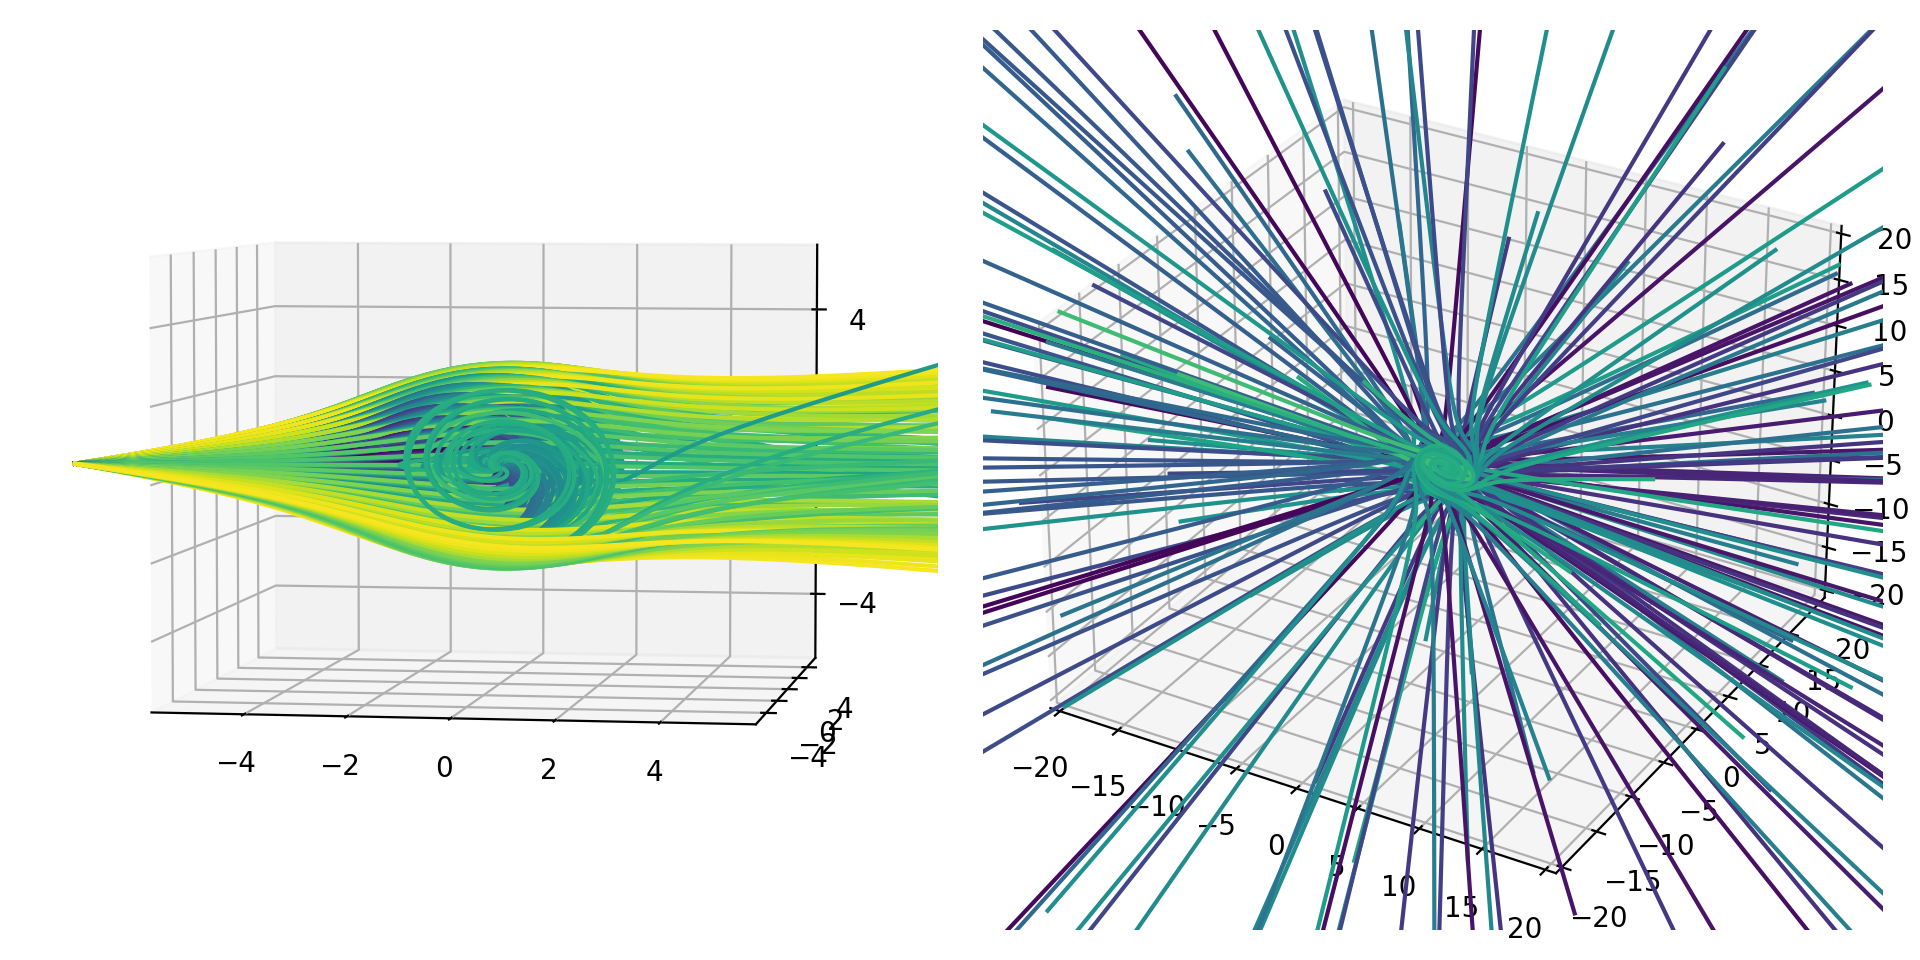

In [28]:
wg.fullplot(Motion1[::10, 1], 21)

In [5]:
import WormholePics as wrmpics
gar = 'four.png'
sat = 'negfour.png'

In [6]:
wormh, CM4= w.wormhole_with_symmetry(1000, initial_q, 1024, 2048, Par, 0.001, True, True)
picture = wrmpics.make_pic_quick(wormh, sat, gar)
np.save('picture', picture)
print('Saving picture')
path = os.getcwd()
cv2.imwrite(os.path.join(path, "Pictures/Image "+"Symm BDF"+str(Par)+" "+str(initial_q)+".png"), picture)
print('Picture saved')

Initializing screen and calculating initial condition...
Integrating ray...



radius saved!
calculating constants of motion
Tijdsduur = 78.64549970626831
Rotating ray...



Ray rotated!
Reading in pictures...
Pictures ready!
Making wormhole...
Wormhole ready!
Saving picture
Picture saved


In [14]:
wormh, CM1 = w.wormhole_with_symmetry(1000, initial_q, 400, 400, Par, 0.01, False, True)
print('Saving picture')
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Symm Sympl"+str(Par)+" "+str(initial_q)+".png"),
            wrmpics.make_pic_quick(wormh, sat, gar))

485.5191419124603
Tijdsduur = 486.3910150527954
Rotating ray...



Ray rotated!
Saving picture
Reading in pictures...
Pictures ready!
Making wormhole...
Wormhole ready!


True

In [ ]:
Motion3, Grid3, CM3  = w.Simulate_DNeg(runge_kutta, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

In [213]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg RK4"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion3[-1, 1], np.zeros(Motion3[-1, 1, 0].shape, dtype=bool)))

True

In [9]:
def simulate_raytracer_fullpath(t_end, Par, q0, N, Nz = 14**2, Ny = 14**2, methode = 'BDF'):
    """
    Solves the differential equations using a build in solver (solve_ivp) with
    specified method.
    Input:  - t_end: endtime of the Integration
            - Par: wormhole parameters
            - q0: position of the camera
            - Nz: number of vertical pixels
            - Ny: number of horizontal pixels
            - methode: method used for solving the ivp (standerd runge-kutta of fourth order)

    Output: - Motion: Usual 5D matrix
    """
    print('Initializing screen and calculating initial condition...')

    # end = int(np.ceil(np.sqrt(Ny**2+Nz**2)))
    M, rho, a = Par

    # Reading out values and determining parameters
    S_c = w.screen_cart(Nz, Ny, 1, 1)
    S_cT = np.transpose(S_c, (2,0,1))
    S_sph = w.cart_Sph(S_cT)
    p, Cst = w.inn_momenta(S_c, S_sph, w.Cst_DNeg, w.inn_mom_DNeg, Par)
    p1, p2, p3 = p
    q1, q2, q3 = q0
    Motion = np.empty((Nz,Ny,6,N))

    # Looping over all momenta
    for j in range(0, len(p1)):
        start_it = time.time()
        for i in range(0, len(p1[0])):
            start_it = time.time()
            initial_values = np.array([q1, q2, q3, p1[j][i], p2[j][i], p3[j][i], M, rho, a, Cst[0,i,j], Cst[1,i,j]])
            # Integrates to the solution
            Motion[j,i] = integr.solve_ivp(w.diff_equations, [t_end, 0], initial_values, method = methode, t_eval=np.linspace(t_end, 0, N)).y[:6]

        end_it = time.time()
        duration = end_it - start_it
        print('Iteration ' + str((j, i)) + ' completed in ' + str(duration) + 's.')
    Motion[:,:,1] = np.mod(Motion[:,:,1], 2*np.pi)
    Motion[:,:,2] = np.mod(Motion[:,:,2], np.pi)
    return np.transpose(np.array([Motion[:,:,0:3], Motion[:,:,3:]]), (4,0,3,1,2)) #output same shape as sympl. intgr.

In [6]:
Motion2 = w.simulate_raytracer_fullpath(500, Par, initial_q, 1000, 20**2, 20**2, 'BDF')

Initializing screen and calculating initial condition...
Iteration (0, 399) completed in 0.05005383491516113s.
Iteration (1, 399) completed in 0.05013680458068848s.
Iteration (2, 399) completed in 0.05089426040649414s.
Iteration (3, 399) completed in 0.04974794387817383s.
Iteration (4, 399) completed in 0.05145597457885742s.
Iteration (5, 399) completed in 0.049449920654296875s.
Iteration (6, 399) completed in 0.05002593994140625s.
Iteration (7, 399) completed in 0.04766225814819336s.
Iteration (8, 399) completed in 0.04801487922668457s.
Iteration (9, 399) completed in 0.04763913154602051s.
Iteration (10, 399) completed in 0.047299861907958984s.
Iteration (11, 399) completed in 0.0485079288482666s.
Iteration (12, 399) completed in 0.04879403114318848s.
Iteration (13, 399) completed in 0.04901909828186035s.
Iteration (14, 399) completed in 0.0463719367980957s.
Iteration (15, 399) completed in 0.04859018325805664s.
Iteration (16, 399) completed in 0.052822113037109375s.
Iteration (17, 39

Iteration (147, 399) completed in 0.04982781410217285s.
Iteration (148, 399) completed in 0.0533907413482666s.
Iteration (149, 399) completed in 0.04941201210021973s.
Iteration (150, 399) completed in 0.0479280948638916s.
Iteration (151, 399) completed in 0.04981184005737305s.
Iteration (152, 399) completed in 0.048975229263305664s.
Iteration (153, 399) completed in 0.049868106842041016s.
Iteration (154, 399) completed in 0.04943418502807617s.
Iteration (155, 399) completed in 0.052678823471069336s.
Iteration (156, 399) completed in 0.049250125885009766s.
Iteration (157, 399) completed in 0.053579092025756836s.
Iteration (158, 399) completed in 0.049352169036865234s.
Iteration (159, 399) completed in 0.0522611141204834s.
Iteration (160, 399) completed in 0.05339169502258301s.
Iteration (161, 399) completed in 0.04796409606933594s.
Iteration (162, 399) completed in 0.05048704147338867s.
Iteration (163, 399) completed in 0.04939913749694824s.
Iteration (164, 399) completed in 0.048710107

Iteration (293, 399) completed in 0.04688882827758789s.
Iteration (294, 399) completed in 0.04677700996398926s.
Iteration (295, 399) completed in 0.045845985412597656s.
Iteration (296, 399) completed in 0.04659605026245117s.
Iteration (297, 399) completed in 0.04490971565246582s.
Iteration (298, 399) completed in 0.04710197448730469s.
Iteration (299, 399) completed in 0.0506589412689209s.
Iteration (300, 399) completed in 0.049178123474121094s.
Iteration (301, 399) completed in 0.052210092544555664s.
Iteration (302, 399) completed in 0.04980182647705078s.
Iteration (303, 399) completed in 0.06190896034240723s.
Iteration (304, 399) completed in 0.05109071731567383s.
Iteration (305, 399) completed in 0.05023908615112305s.
Iteration (306, 399) completed in 0.047753095626831055s.
Iteration (307, 399) completed in 0.04789996147155762s.
Iteration (308, 399) completed in 0.04956388473510742s.
Iteration (309, 399) completed in 0.0502321720123291s.
Iteration (310, 399) completed in 0.0492060184

In [61]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

In [7]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg scipy BDF"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], np.zeros(Motion2[-1, 1, 0].shape, dtype=bool)))

True

(24616748,) (1000, 400, 400)
(45234,) (1000, 18, 18)
True


<IPython.core.display.Javascript object>


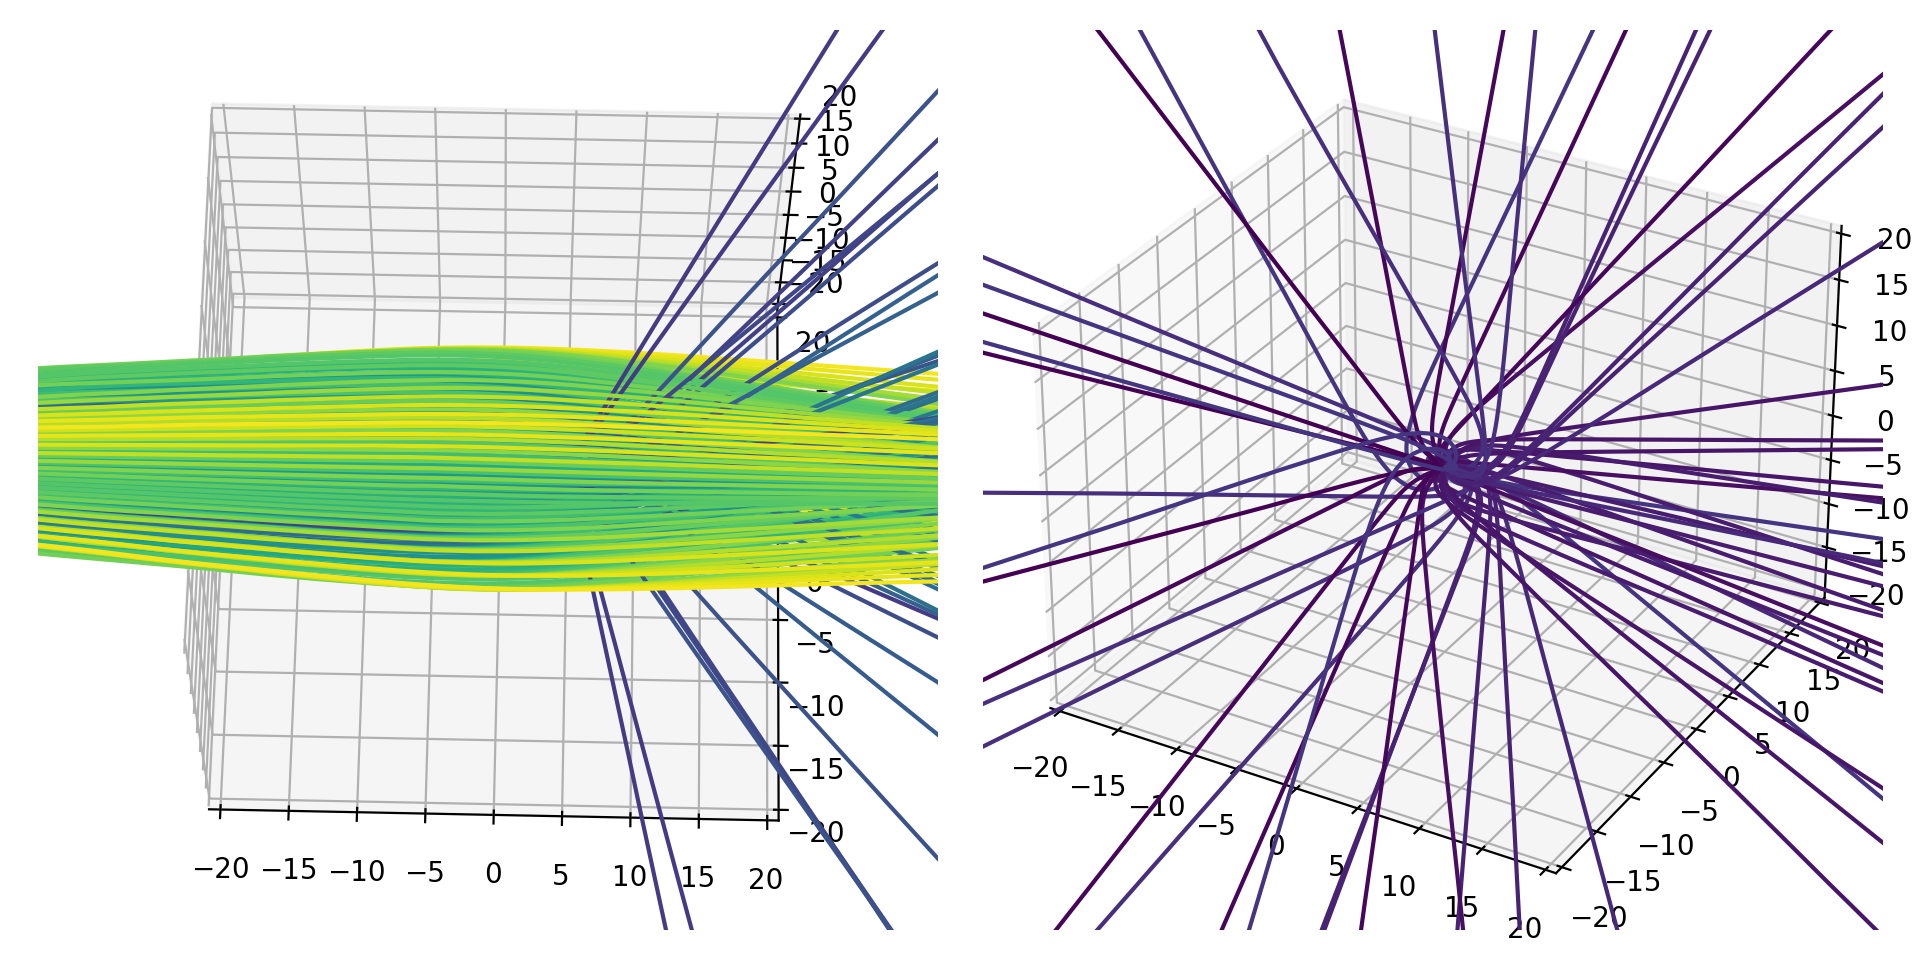

In [10]:
wg.fullplot(Motion2[:, 1], 23)

In [48]:
plt.cm.viridis(np.arange(5)/5)

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.253935, 0.265254, 0.529983, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.477504, 0.821444, 0.318195, 1.      ]])

<IPython.core.display.Javascript object>


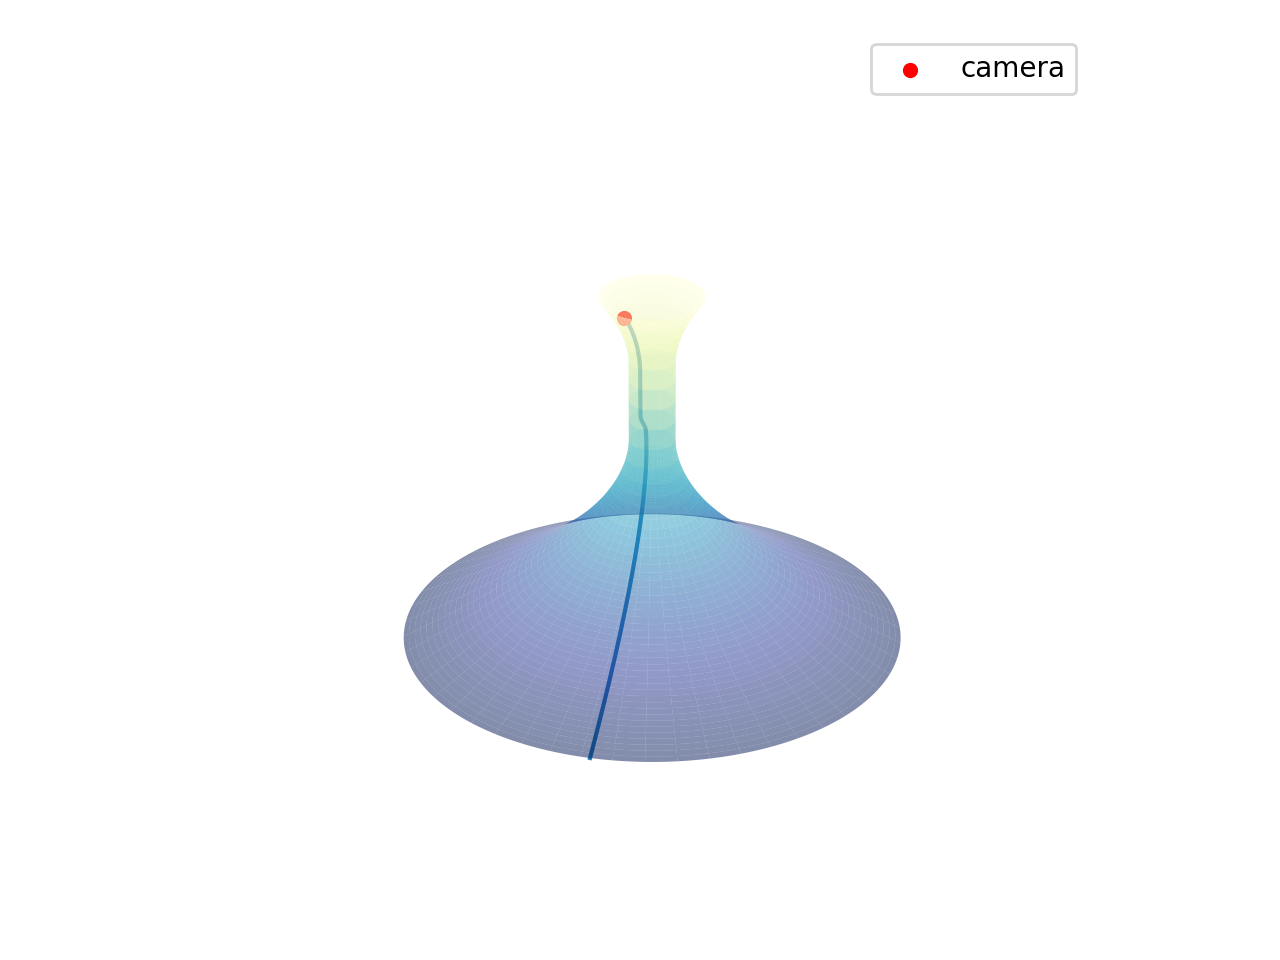

In [74]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
#Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion2, Par, "Pictures/Noise "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [62]:
"def plot_CM(CM, Label, name, path):
    #input: 3D array containing energy of each ray over time, advancement in time on first row
    # plot the constants of motion over the partition of the rays
  
    Sh = CM[0,0].shape
    if len(Sh) > 1:
        Ny, Nz = Sh
        cl, ind = ray_spread(Nz, Ny)
        CM = np.transpose(CM, (1,0,2,3))
    else:
        N = Sh[0]
        cl = plt.cm.viridis(np.arange(N)/N)
        CM = np.transpose(CM, (1,0,2))
    N_C = len(CM)
    fig, ax = plt.subplots(1, N_C)
    x = np.arange(len(CM[0]))
    for k in range(N_C):
        if len(Sh) > 1:
            for i in range(Nz):
                for j in range(Ny):
                    ij = i + Nz*j
                    cl_i =cl[ind[ij]]
                    ax[k].plot(x, CM[k,:,i,j], color=cl_i)
        else:
            for i in range(N):
                ax[k].plot(x, CM[k,:,i], color=cl[i])        
        ax[k].set_yscale("symlog")
        #ax[k].set_title(Label[k] + ",  Donker pixels binnenkant scherm, lichte pixels buitenkant")
        ax[k].set_xlabel("number of timesteps taken")
        ax[k].set_ylabel(Label[k])
        ax[k].set_title("sum subdivision rays")
    plt.tight_layout()
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()"


In [31]:
CM1.shape

(10000, 3, 400, 400)

In [11]:
CM2 = np.array([w.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

<IPython.core.display.Javascript object>


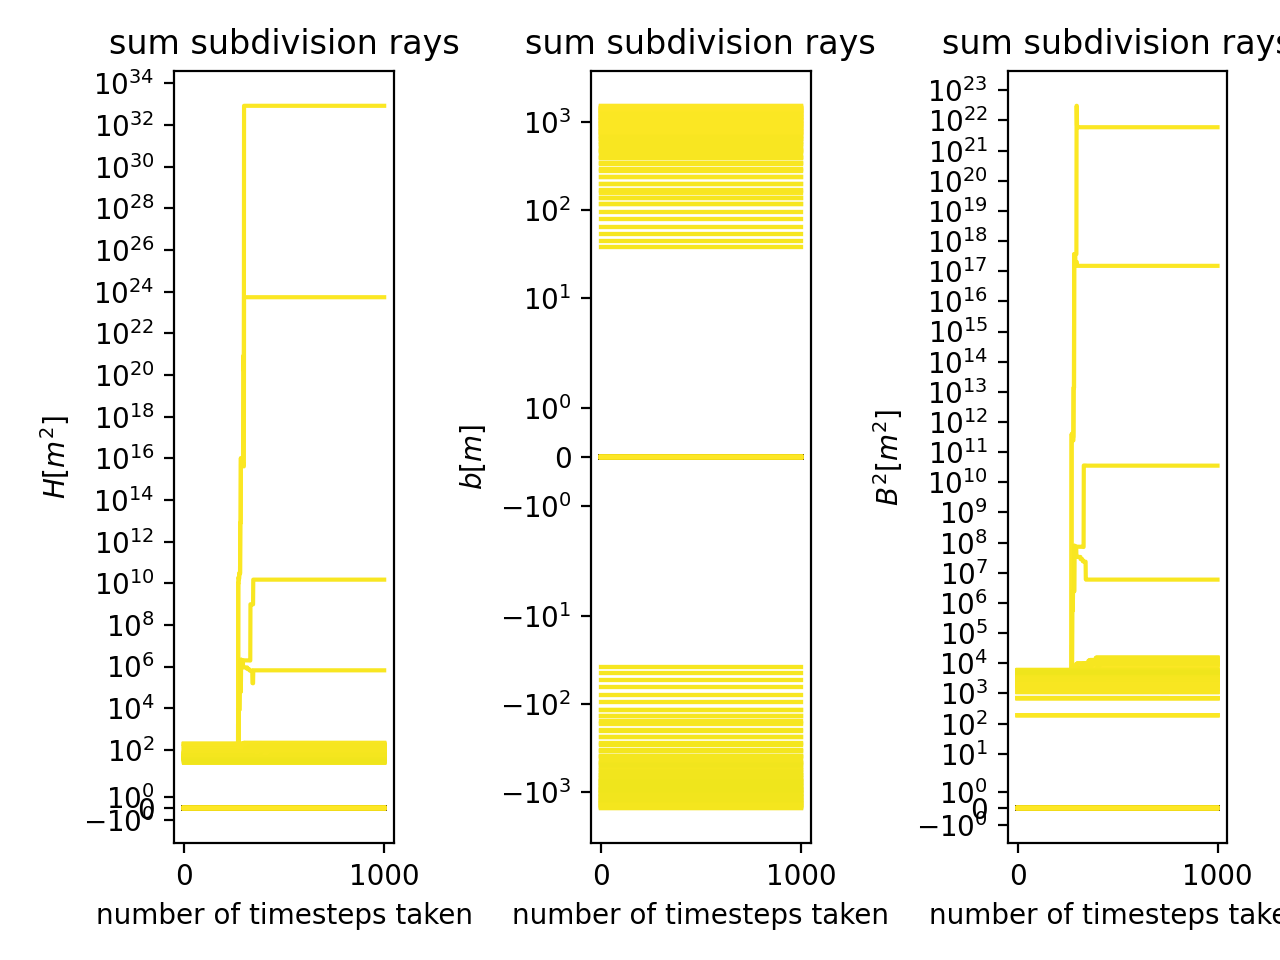

In [32]:
wg.plot_CM(CM1[::10], ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


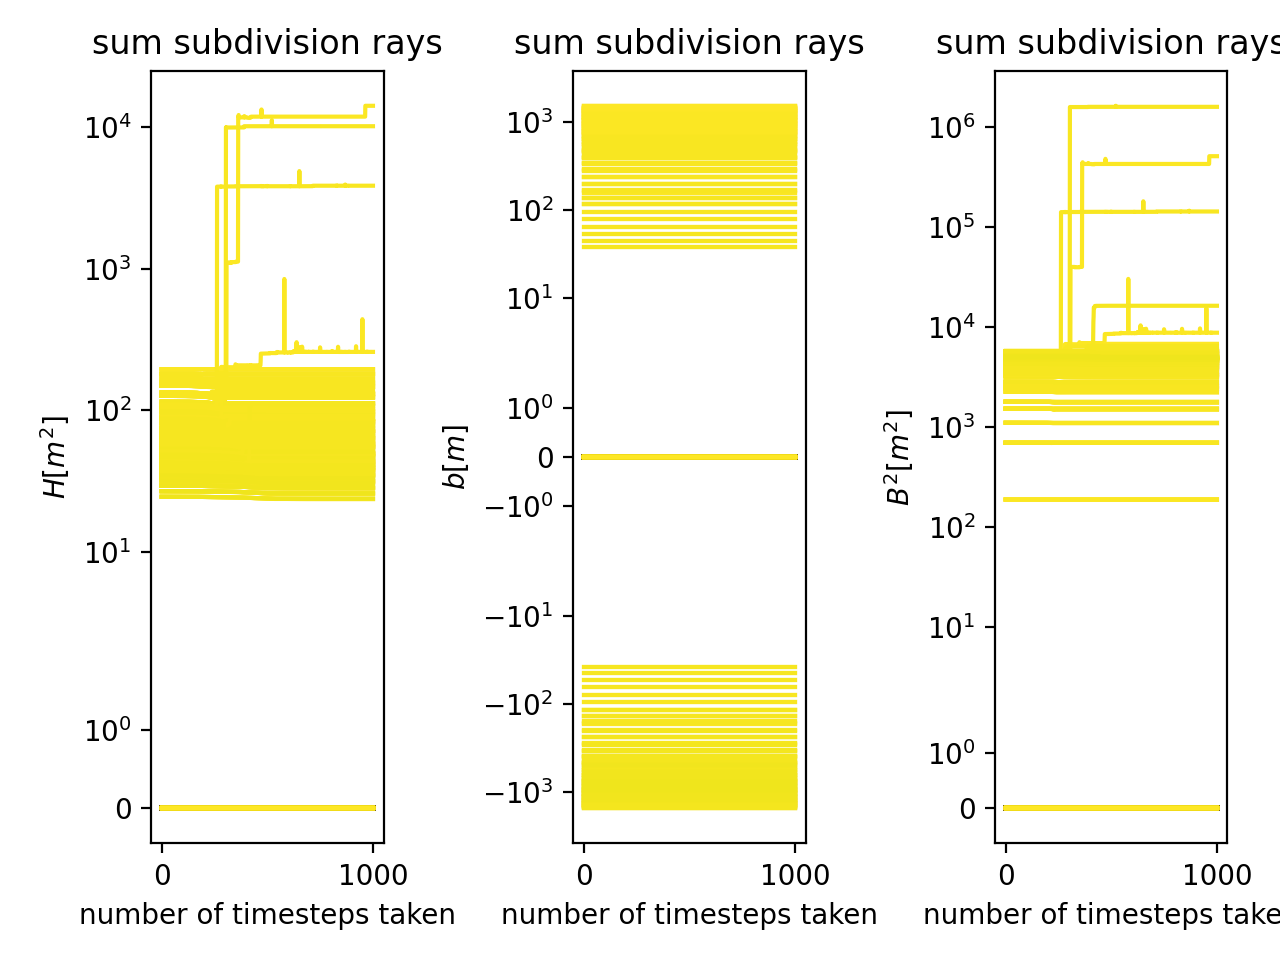

In [12]:
wg.plot_CM(CM2, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg BDF"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


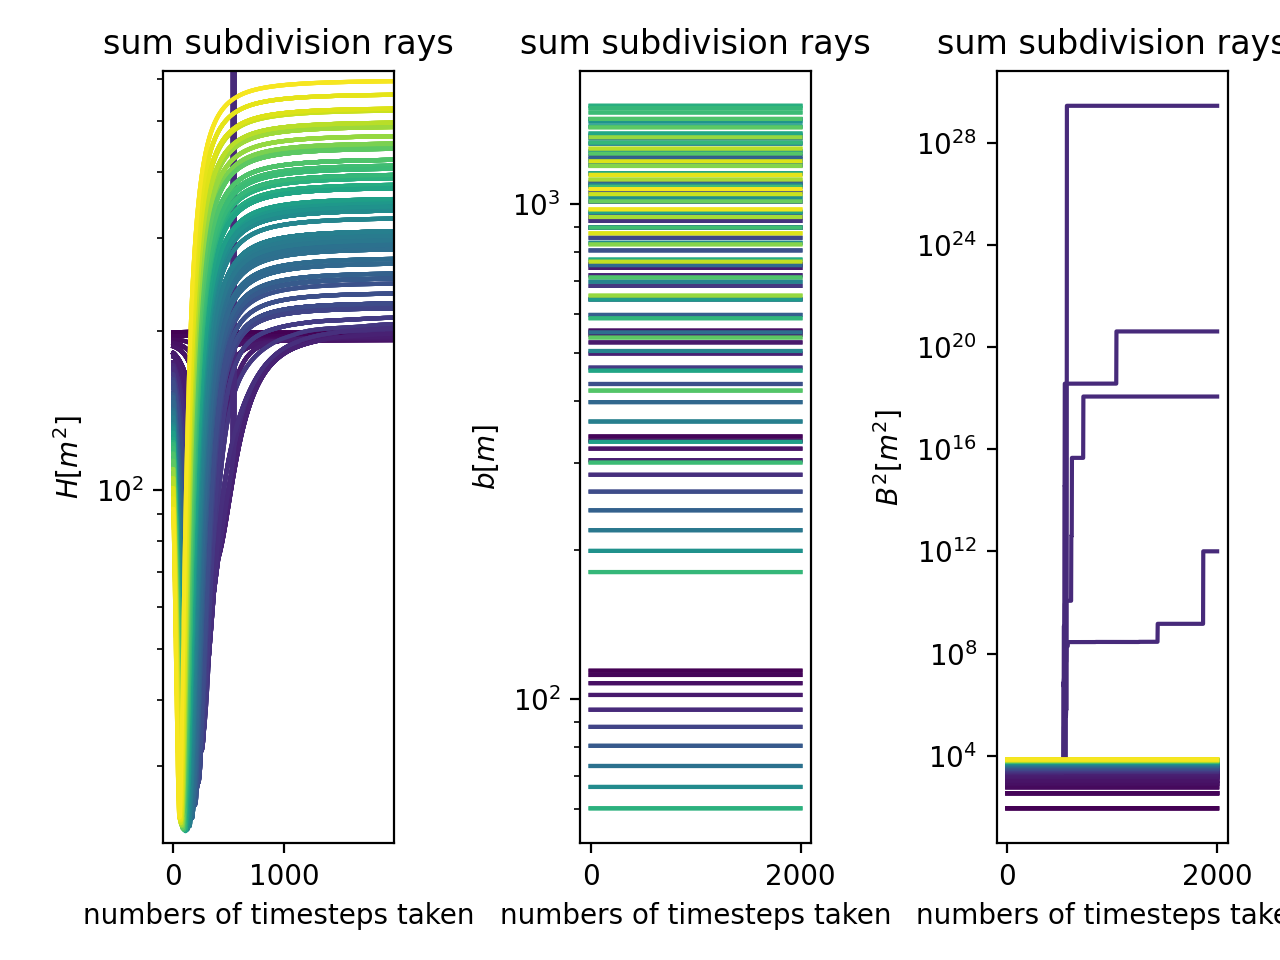

In [60]:
wg.plot_CM(CM3, ['$H$[$m^{2}$]', '$b$[$m$]', '$B^{2}$[$m^{2}$]'], "Pictures/CM DNeg RK4"+str(Par)+" "+str(initial_q)+".png", path)

<IPython.core.display.Javascript object>


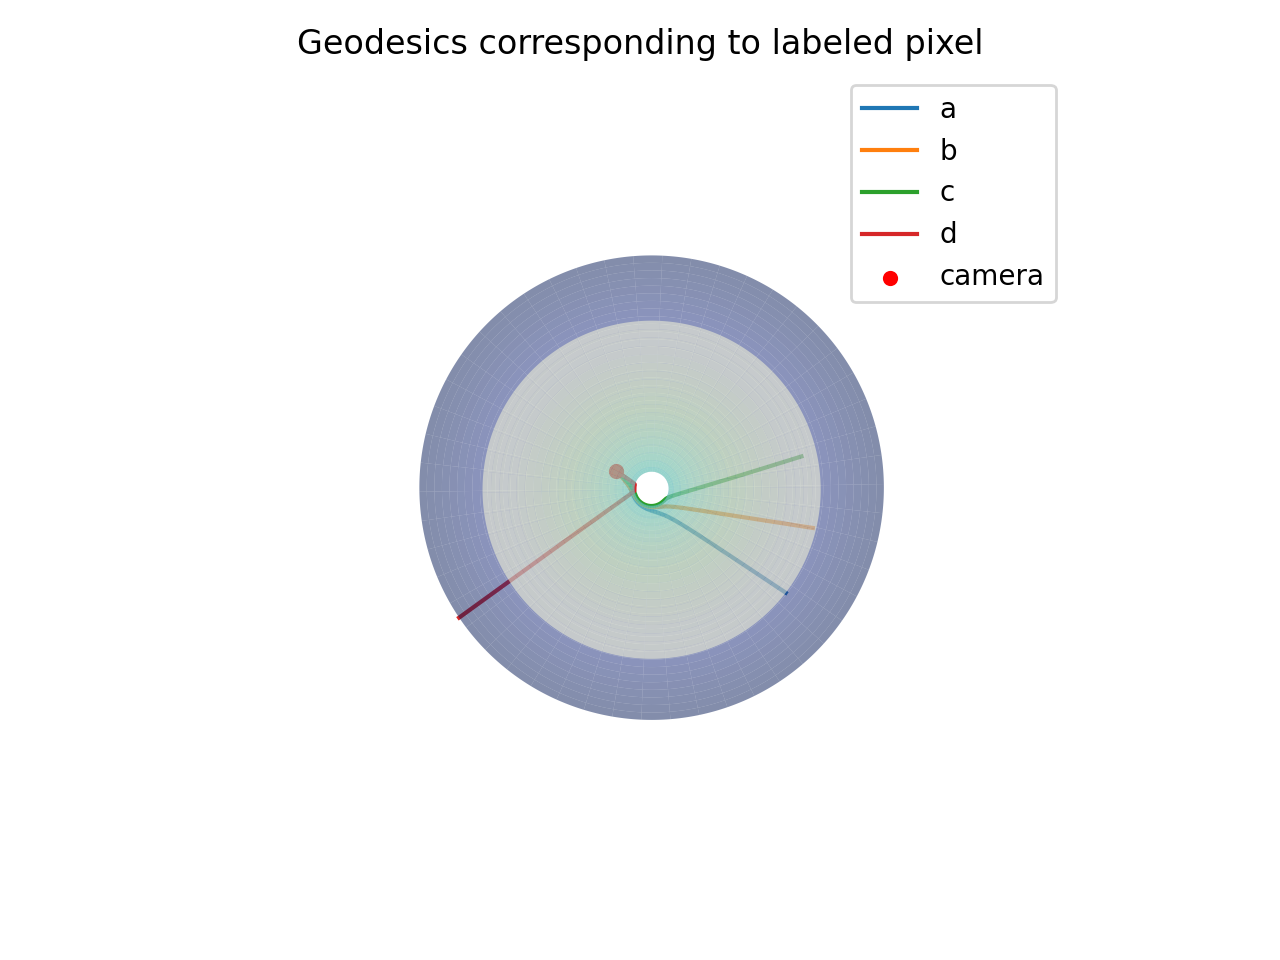

In [63]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion1, Par, "Pictures/geodesics "+Geo_txt+" DNeg Sympl"+str(Par)+" "+str(initial_q)+".png",
        path, Geo_label, Geo_Sel)

<IPython.core.display.Javascript object>


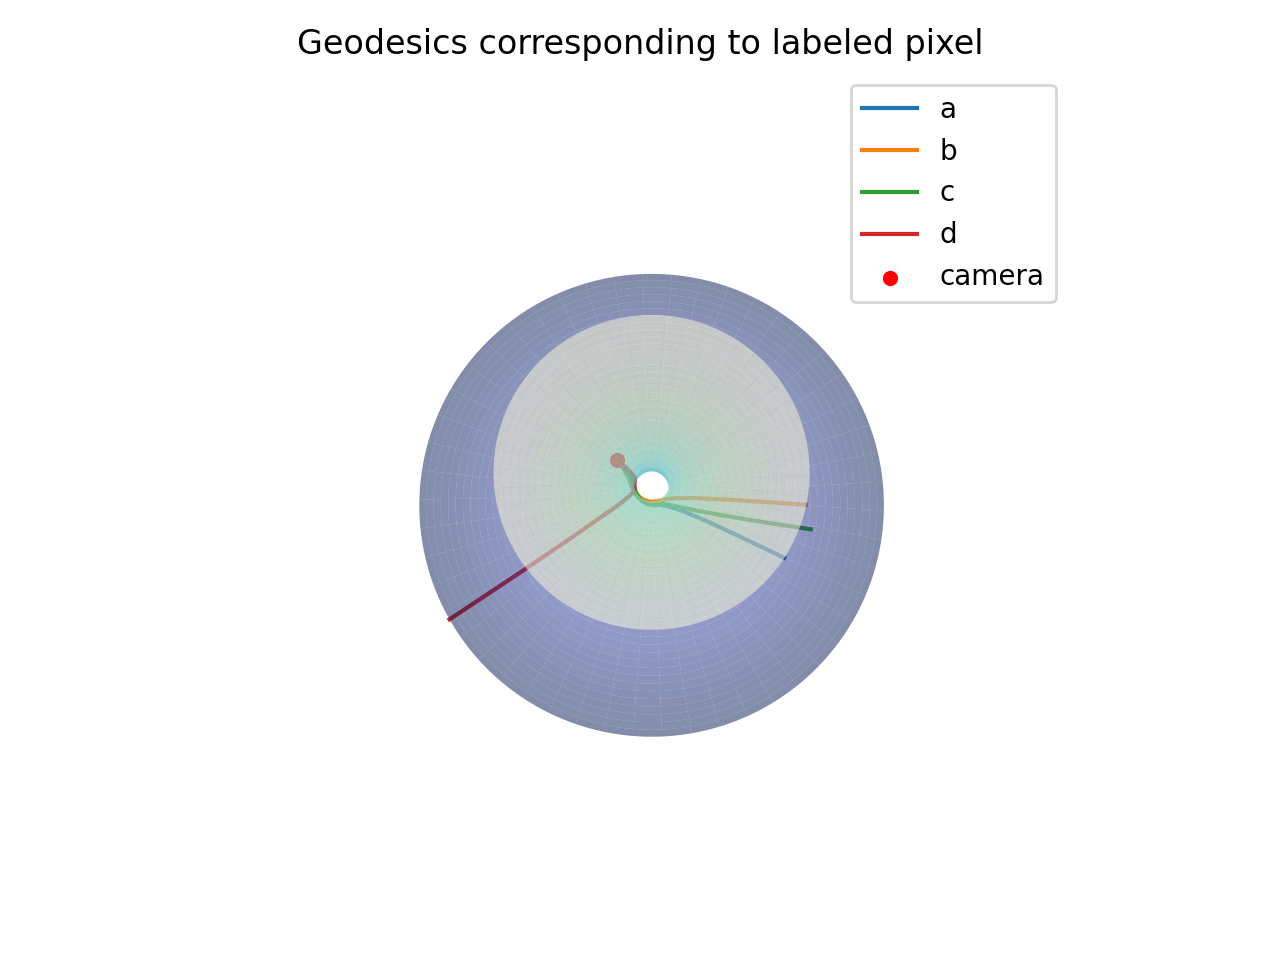

In [67]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[4,4],[36,11],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion2, Par, "Pictures/geodesics "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

<IPython.core.display.Javascript object>


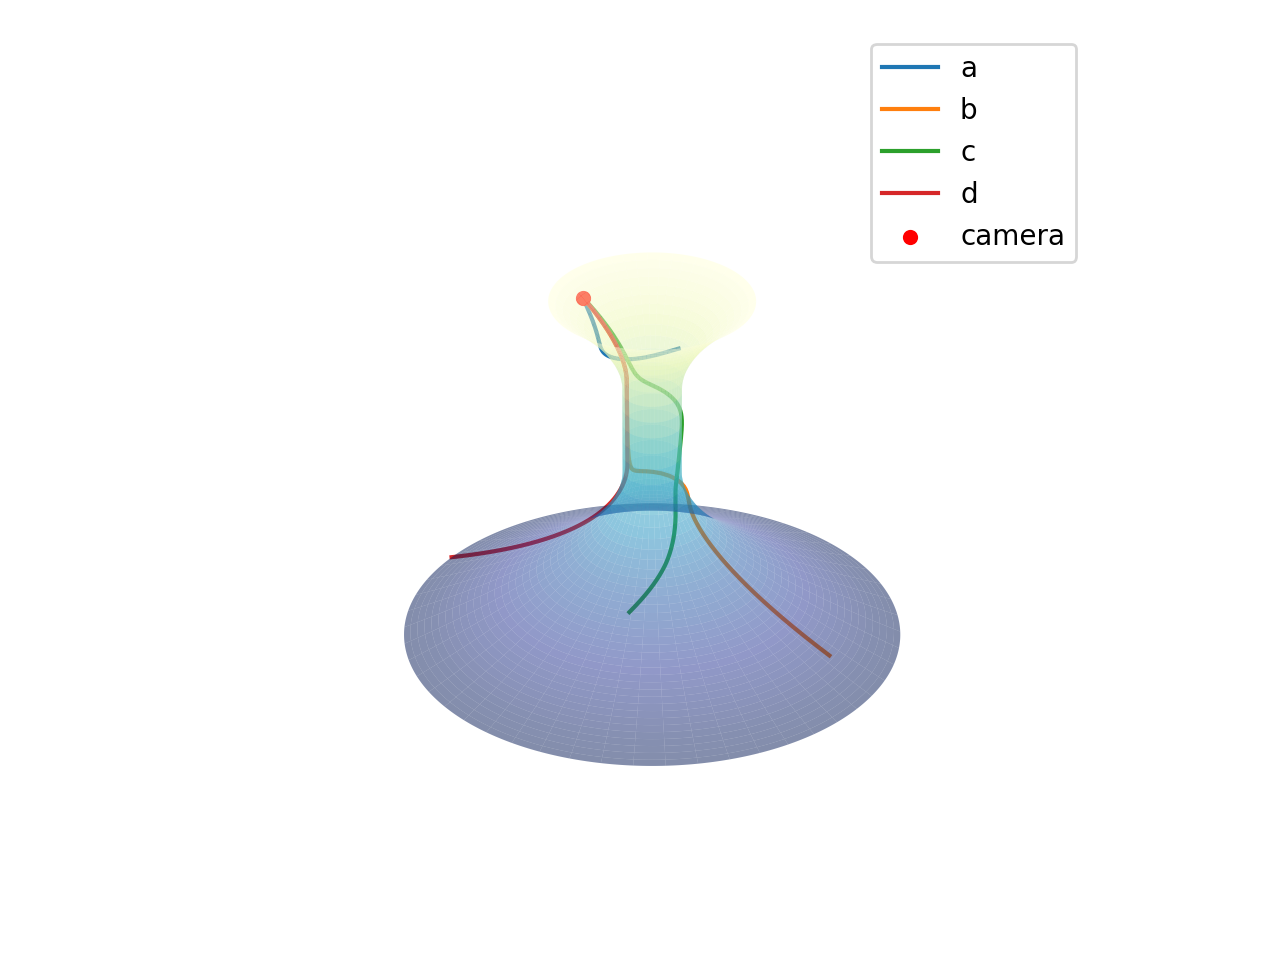

In [30]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
Geo_Sel = [[4,4],[36,50],[71,58], [50,50]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
#Geo_Sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
wg.gdsc(Motion2, Par, "Pictures/geodesics "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [15]:
Motion2.shape

(500, 2, 3, 100, 100)

In [1]:
def empty_color(Ny,Nz):
    phi = np.linspace(0, 2*np.pi, Ny)
    theta = np.linspace(0, np.pi, Nz)
    pic = np.empty(Nz, Ny)
    for j in range(Nz):
        for i in range(Ny):
            pic[j,i] = np.array([1, phi[i], theta[j]])
    return np.transpose(pic, (2,0,1))

def Grid_constr_2D_Cart(q, N_a, R, w, Slice = None):
    # input: q: matrix with coordinates in configuration space on first row
    #        N_a: subdivision angles
    #        R: linspace radius to form grid 
    #        w: ratio
    #output: 2D boolean array
    Nz, Ny =  q[0].shape
    if np.any(Slice == None):
        Slice = np.zeros((Nz, Ny), dtype=bool)
    Slice_inv = ~Slice
    x, y, z = Sph_cart(q)
    
    # Defines point on spherical grid
    xx = x[Slice_inv]
    on_x = (np.abs(R - np.mod(xx, R)) < R*w) | (np.abs(np.mod(xx, R) - R) < R*w)
    yy = y[Slice_inv]
    on_y = (np.abs(R - np.mod(yy, R)) < R*w) | (np.abs(np.mod(yy, R) - R) < R*w)
    zz = z[Slice_inv]
    on_z = (np.abs(R - np.mod(zz, R)) < R*w) | (np.abs(np.mod(zz, R) - R) < R*w)
    # Boolean conditions for when rays lands on spherical grid
    Slice[Slice_inv] = (on_x & on_z) | (on_y & on_z) | (on_x & on_y)
    return Slice